# Test SSL-ALPnet on Ovatus Dataset

This notebook implements a testing pipeline for the SSL-ALPnet model using the Ovatus dataset (Ovarian Cysts).
It adapts the data loading from `universeg_analization_Ovatus_02-01.ipynb` and feeds it into the SSL-ALPnet inference engine.

In [1]:
import os
import sys
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2
import pandas as pd

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('.'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, '.')

from models.grid_proto_fewshot import FewShotSeg

%matplotlib inline
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.13.1+cu116
CUDA available: True


## 1. Configuration

In [2]:
# ================= CONFIG =================
# Dataset paths - CẬP NHẬT THEO MÁY BẠN
DATA_ROOT = "/thiends/hdd2t/UniverSeg/US_map4"  # Thư mục chứa các folder bệnh nhân
ANNOT_PATH = "/thiends/hdd2t/UniverSeg/mapping_normalized4.jsonl"  # File annotation

# Model paths
MODEL_PATH = "./runs/mySSL_CHAOST2_Superpix_sets_0_1shot/1/snapshots/100000.pth"  # Path to trained model

# Image settings
RESIZE_TO = (256, 256)  # SSL_ALPNet uses 256x256
INPUT_SIZE = (256, 256)

# Model settings
MODEL_CONFIG = {
    'align': True,
    'use_coco_init': True,
    'which_model': 'dlfcn_res101',
    'cls_name': 'grid_proto',
    'proto_grid_size': 8,
    'feature_hw': [32, 32],
    'reload_model_path': None
}

# Label mapping for Ovatus dataset
LABEL2ID = {
    "nang_da_thuy": 0,
    "nang_don_thuy": 1,
    "nang_da_thuy_dac": 2,
    "nang_don_thuy_dac": 3,
    "u_bi": 4,
    "u_dac": 5
}
NUM_CLASSES = len(LABEL2ID)
LABEL_NAMES = list(LABEL2ID.keys())

# Evaluation settings
VAL_WSIZE = 2  # Validation window size for prototype pooling
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Data root: {DATA_ROOT}")
print(f"Image size: {RESIZE_TO}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {LABEL_NAMES}")

Device: cuda
Data root: /thiends/hdd2t/UniverSeg/US_map4
Image size: (256, 256)
Number of classes: 6
Classes: ['nang_da_thuy', 'nang_don_thuy', 'nang_da_thuy_dac', 'nang_don_thuy_dac', 'u_bi', 'u_dac']


## 2. Dataset Loading Utilities

In [3]:
def polygon_to_mask(points, image_size, resize_to):
    """Convert polygon points to binary mask"""
    try:
        mask = Image.new('L', image_size, 0)
        if points is not None and len(points) >= 3:
            ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
        mask = mask.resize(resize_to, Image.NEAREST)
        return np.array(mask, dtype=np.float32)
    except Exception:
        return None


def process_image(image_path, resize_to):
    """
    Load and preprocess image for SSL_ALPNet
    - Converts to RGB
    - Resizes to target size
    - Normalizes (per-image normalization)
    - Returns [3, H, W] tensor
    """
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(resize_to, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        # Per-image normalization (similar to medical image normalization)
        img = (img - img.mean()) / (img.std() + 1e-8)
        return np.transpose(img, (2, 0, 1))  # [3, H, W]
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

## 3. Ovatus Dataset Class

In [4]:
class OvatusDataset:
    """
    Ovatus Dataset loader for SSL_ALPNet
    Loads data from JSONL annotation file
    """
    def __init__(self, annot_path=ANNOT_PATH, data_root=DATA_ROOT, resize_to=RESIZE_TO):
        self.samples = []
        self.samples_by_class = defaultdict(list)
        self.data_root = data_root
        self.resize_to = resize_to

        print("=" * 70)
        print("Loading OvatusDataset (JSONL format)...")
        print("=" * 70)

        with open(annot_path, "r", encoding="utf-8") as f:
            for line_idx, line in enumerate(f):
                try:
                    item = json.loads(line)
                except Exception:
                    continue

                patient = item.get("patient_name", None)
                if patient is None:
                    continue

                for img_info in item.get("images", []):
                    img_name = img_info.get("image_name", None)
                    if img_name is None:
                        continue

                    img_path = os.path.join(data_root, patient, img_name)
                    if not os.path.exists(img_path):
                        continue

                    # Load image
                    img = process_image(img_path, resize_to)
                    if img is None:
                        continue

                    image_size = (
                        img_info.get("imageWidth"),
                        img_info.get("imageHeight")
                    )
                    if None in image_size:
                        continue

                    # Create masks for each class
                    masks = np.zeros(
                        (NUM_CLASSES, resize_to[1], resize_to[0]),
                        dtype=np.float32
                    )

                    labels = img_info.get("labels", [])
                    polygons_list = img_info.get("points", [])

                    has_valid_mask = False

                    for lbl, poly_pts in zip(labels, polygons_list):
                        if lbl not in LABEL2ID:
                            continue
                        if not poly_pts or len(poly_pts) < 3:
                            continue

                        pts = [tuple(map(float, pt)) for pt in poly_pts]
                        mask = polygon_to_mask(pts, image_size, resize_to)
                        if mask is None:
                            continue

                        class_id = LABEL2ID[lbl]
                        masks[class_id] = np.maximum(masks[class_id], mask)
                        has_valid_mask = True

                    # Skip if no valid mask
                    if not has_valid_mask:
                        continue

                    # Store sample for each class that has annotation
                    for class_id in range(NUM_CLASSES):
                        if masks[class_id].sum() > 10:  # Has significant mask
                            sample = {
                                'image': img,
                                'mask': masks[class_id],  # Single class mask [H, W]
                                'class': class_id,
                                'img_path': img_path,
                                'patient': patient
                            }
                            self.samples.append(sample)
                            self.samples_by_class[class_id].append(len(self.samples) - 1)

        print(f"Loaded {len(self.samples)} valid samples.")
        print(f"\nClass distribution:")
        for class_id in range(NUM_CLASSES):
            count = len(self.samples_by_class[class_id])
            print(f"  [{class_id}] {LABEL_NAMES[class_id]:25}: {count:3d} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

    def get_samples_by_class(self, cls):
        """Get all sample indices for a specific class"""
        return self.samples_by_class.get(cls, [])

## 4. Load Dataset and Split

In [5]:
# Load full dataset
dataset = OvatusDataset()
print(f"\nTotal samples: {len(dataset)}")

Loading OvatusDataset (JSONL format)...
Loaded 605 valid samples.

Class distribution:
  [0] nang_da_thuy             : 151 samples
  [1] nang_don_thuy            : 108 samples
  [2] nang_da_thuy_dac         :  62 samples
  [3] nang_don_thuy_dac        :  31 samples
  [4] u_bi                     : 116 samples
  [5] u_dac                    : 137 samples

Total samples: 605


In [6]:
# Patient-level split (80% support, 20% test)
def patient_level_split(dataset, split_ratio=0.8, seed=42):
    """
    Split dataset by patient (subject-level split)
    """
    from torch.utils.data import Subset
    
    patient_to_indices = {}
    
    for idx in range(len(dataset)):
        sample = dataset[idx]
        patient = sample['patient']
        patient_to_indices.setdefault(patient, []).append(idx)
    
    patients = list(patient_to_indices.keys())
    print(f"\nTotal patients: {len(patients)}")
    
    rng = np.random.default_rng(seed)
    rng.shuffle(patients)
    
    n_support = int(split_ratio * len(patients))
    support_patients = patients[:n_support]
    test_patients = patients[n_support:]
    
    support_idxs = [i for p in support_patients for i in patient_to_indices[p]]
    test_idxs = [i for p in test_patients for i in patient_to_indices[p]]
    
    print(f"Support: {len(support_patients)} patients, {len(support_idxs)} samples")
    print(f"Test: {len(test_patients)} patients, {len(test_idxs)} samples")
    
    # Create subset datasets
    class SubsetDataset:
        def __init__(self, dataset, indices):
            self.dataset = dataset
            self.indices = indices
            # Build class mapping
            self.samples_by_class = defaultdict(list)
            for new_idx, orig_idx in enumerate(indices):
                cls = dataset[orig_idx]['class']
                self.samples_by_class[cls].append(new_idx)
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.dataset[self.indices[idx]]
        
        def get_samples_by_class(self, cls):
            return self.samples_by_class.get(cls, [])
    
    support_pool = SubsetDataset(dataset, support_idxs)
    test_set = SubsetDataset(dataset, test_idxs)
    
    return support_pool, test_set

support_pool, test_set = patient_level_split(dataset, split_ratio=0.8, seed=42)

print("\n📊 Support pool class distribution:")
for cls in range(NUM_CLASSES):
    count = len(support_pool.get_samples_by_class(cls))
    print(f"  [{cls}] {LABEL_NAMES[cls]:25}: {count:3d} samples")

print("\n📊 Test set class distribution:")
for cls in range(NUM_CLASSES):
    count = len(test_set.get_samples_by_class(cls))
    print(f"  [{cls}] {LABEL_NAMES[cls]:25}: {count:3d} samples")


Total patients: 293
Support: 234 patients, 473 samples
Test: 59 patients, 132 samples

📊 Support pool class distribution:
  [0] nang_da_thuy             : 127 samples
  [1] nang_don_thuy            :  83 samples
  [2] nang_da_thuy_dac         :  49 samples
  [3] nang_don_thuy_dac        :  18 samples
  [4] u_bi                     :  92 samples
  [5] u_dac                    : 104 samples

📊 Test set class distribution:
  [0] nang_da_thuy             :  24 samples
  [1] nang_don_thuy            :  25 samples
  [2] nang_da_thuy_dac         :  13 samples
  [3] nang_don_thuy_dac        :  13 samples
  [4] u_bi                     :  24 samples
  [5] u_dac                    :  33 samples


## 5. Load SSL_ALPNet Model

In [7]:
def load_model(model_path=None, config=MODEL_CONFIG):
    """
    Load SSL_ALPNet model (FewShotSeg)
    """
    print("Loading SSL_ALPNet model...")
    
    model = FewShotSeg(pretrained_path=model_path, cfg=config)
    model = model.to(DEVICE)
    model.eval()
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"   ✅ Model loaded successfully!")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    return model

# Load model
# Option 1: Load pretrained weights
# model = load_model(MODEL_PATH, MODEL_CONFIG)

# Option 2: Use COCO-initialized model (no finetuning)
model = load_model(None, MODEL_CONFIG)

print(f"\nModel is on: {next(model.parameters()).device}")

Loading SSL_ALPNet model...


/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


###### NETWORK: Using ms-coco initialization ######
   ✅ Model loaded successfully!
   Total parameters: 59,214,912
   Trainable parameters: 59,214,912

Model is on: cuda:0


## 6. Inference Functions

In [8]:
def prepare_support_data(support_samples, target_class):
    """
    Prepare support images and masks for SSL_ALPNet
    
    SSL_ALPNet expects:
    - supp_imgs: way x shot x [B x 3 x H x W]
    - fore_mask: way x shot x [B x H x W]
    - back_mask: way x shot x [B x H x W]
    """
    support_images = []
    support_fg_masks = []
    support_bg_masks = []
    
    for sample in support_samples:
        # Image: [1, 3, H, W]
        img = torch.from_numpy(sample['image']).float().unsqueeze(0).to(DEVICE)
        
        # Mask: [H, W] -> [1, H, W]
        mask = torch.from_numpy(sample['mask']).float().to(DEVICE)
        fg_mask = mask.unsqueeze(0)  # [1, H, W]
        bg_mask = (1 - mask).unsqueeze(0)  # [1, H, W]
        
        support_images.append(img)
        support_fg_masks.append(fg_mask)
        support_bg_masks.append(bg_mask)
    
    # Format: way(1) x shot(n) x [B x C x H x W]
    supp_imgs = [support_images]  # 1 way, n shots
    fore_mask = [support_fg_masks]  # 1 way, n shots
    back_mask = [support_bg_masks]  # 1 way, n shots
    
    return supp_imgs, fore_mask, back_mask


def prepare_query_data(query_sample):
    """
    Prepare query image for SSL_ALPNet
    """
    img = torch.from_numpy(query_sample['image']).float().unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    qry_imgs = [img]
    
    gt_mask = torch.from_numpy(query_sample['mask']).float().to(DEVICE)
    
    return qry_imgs, gt_mask


@torch.no_grad()
def inference(model, support_samples, query_sample, val_wsize=VAL_WSIZE):
    """
    Run SSL_ALPNet inference
    
    Returns:
        pred_fg: Foreground probability [H, W]
        pred_binary: Binary prediction [H, W]
        gt_mask: Ground truth [H, W]
    """
    model.eval()
    target_class = query_sample['class']
    
    # Prepare data
    supp_imgs, fore_mask, back_mask = prepare_support_data(support_samples, target_class)
    qry_imgs, gt_mask = prepare_query_data(query_sample)
    
    # Forward pass
    query_pred, _, _, _ = model(
        supp_imgs, 
        fore_mask, 
        back_mask, 
        qry_imgs, 
        isval=True, 
        val_wsize=val_wsize
    )
    
    # query_pred shape: [1, 2, H, W] (background, foreground)
    pred_softmax = F.softmax(query_pred, dim=1)
    pred_fg = pred_softmax[0, 1]  # Foreground probability [H, W]
    pred_binary = (pred_fg > 0.5).float()
    
    return pred_fg, pred_binary, gt_mask

## 7. Metrics and Support Selection

In [9]:
def compute_metrics(pred_binary, gt, smooth=1e-6):
    """
    Compute segmentation metrics: Dice, IoU, Precision, Recall
    """
    pred_binary = pred_binary.float()
    gt = gt.float()
    
    TP = (pred_binary * gt).sum()
    FP = (pred_binary * (1 - gt)).sum()
    FN = ((1 - pred_binary) * gt).sum()
    
    dice = (2 * TP + smooth) / (2 * TP + FP + FN + smooth)
    iou = (TP + smooth) / (TP + FP + FN + smooth)
    precision = (TP + smooth) / (TP + FP + smooth)
    recall = (TP + smooth) / (TP + FN + smooth)
    
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item()
    }


def random_support_selection(support_pool, target_class, n_shots):
    """
    Randomly select n_shots support samples for target class
    """
    class_indices = support_pool.get_samples_by_class(target_class)
    
    if len(class_indices) == 0:
        return []
    
    n_select = min(n_shots, len(class_indices))
    selected_indices = np.random.choice(class_indices, size=n_select, replace=False)
    
    return [support_pool[idx] for idx in selected_indices]


def get_best_support_samples(support_pool, target_class, n_shots, strategy='random'):
    """
    Get support samples based on selection strategy
    """
    if strategy == 'random':
        return random_support_selection(support_pool, target_class, n_shots)
    else:
        raise NotImplementedError(f"Strategy {strategy} not implemented")

## 8. Quick Test

Running quick inference test...
Query class: u_bi (ID: 4)
Number of support samples: 4

Metrics:
  Dice: 0.7171
  IoU: 0.5590
  Precision: 0.5889
  Recall: 0.9166


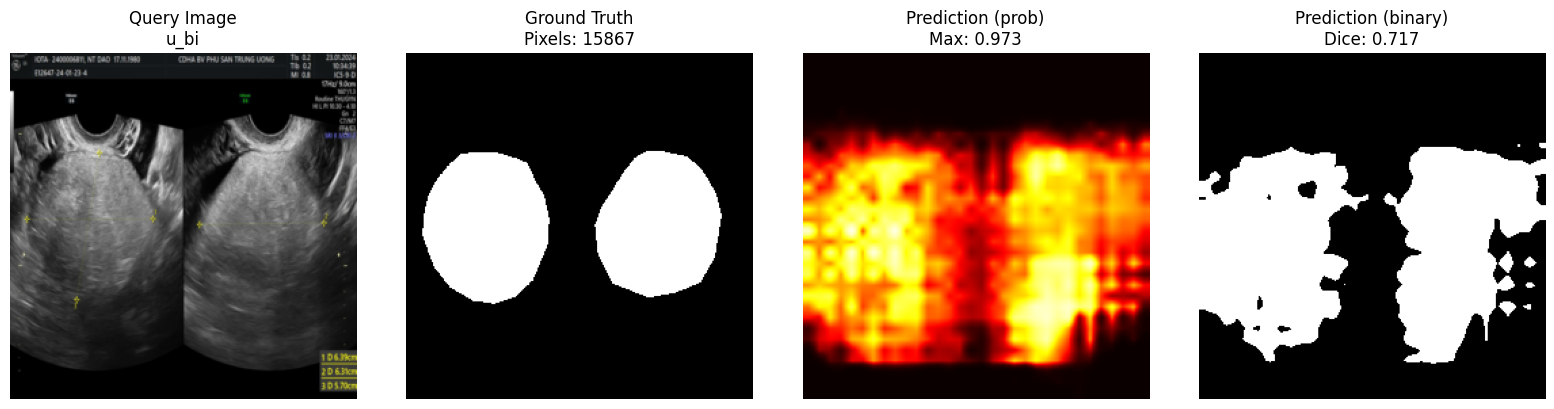

In [10]:
# Quick test with one sample
print("Running quick inference test...")

# Find a test sample with valid mask
test_sample = None
for idx in range(len(test_set)):
    sample = test_set[idx]
    if sample['mask'].sum() > 100:
        test_sample = sample
        break

if test_sample is not None:
    target_class = test_sample['class']
    print(f"Query class: {LABEL_NAMES[target_class]} (ID: {target_class})")
    
    # Get support samples
    support_samples = get_best_support_samples(support_pool, target_class, n_shots=4)
    print(f"Number of support samples: {len(support_samples)}")
    
    if len(support_samples) > 0:
        # Run inference
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, test_sample)
        
        # Compute metrics
        metrics = compute_metrics(pred_binary, gt_mask)
        print(f"\nMetrics:")
        print(f"  Dice: {metrics['dice']:.4f}")
        print(f"  IoU: {metrics['iou']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        
        # Visualize
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Query image
        img_show = test_sample['image'].transpose(1, 2, 0)
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)
        axes[0].imshow(img_show)
        axes[0].set_title(f"Query Image\n{LABEL_NAMES[target_class]}")
        axes[0].axis('off')
        
        # Ground truth
        axes[1].imshow(gt_mask.cpu().numpy(), cmap='gray')
        axes[1].set_title(f"Ground Truth\nPixels: {gt_mask.sum():.0f}")
        axes[1].axis('off')
        
        # Prediction probability
        axes[2].imshow(pred_prob.cpu().numpy(), cmap='hot', vmin=0, vmax=1)
        axes[2].set_title(f"Prediction (prob)\nMax: {pred_prob.max():.3f}")
        axes[2].axis('off')
        
        # Binary prediction
        axes[3].imshow(pred_binary.cpu().numpy(), cmap='gray')
        axes[3].set_title(f"Prediction (binary)\nDice: {metrics['dice']:.3f}")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No support samples found for class {target_class}")
else:
    print("No valid test sample found!")

## 9. Evaluation by N-Shot

In [11]:
# ================== EVALUATE BY N-SHOT ==================
print("=" * 80)
print("EVALUATING SSL_ALPNet ON OVATUS - METRICS BY N-SHOT")
print("=" * 80)

N_SHOTS_LIST = [1, 2, 4, 8, 16, 32]
NUM_TEST_SAMPLES = len(test_set)  # Use all test samples

results_by_N = {N: {'dice': [], 'iou': [], 'precision': [], 'recall': []} for N in N_SHOTS_LIST}

print(f"\nEvaluating on {NUM_TEST_SAMPLES} test samples...\n")

for idx in tqdm(range(NUM_TEST_SAMPLES), desc="Evaluating"):
    query_sample = test_set[idx]
    target_class = query_sample['class']
    
    # Skip if mask too small
    if query_sample['mask'].sum() < 10:
        continue
    
    for N in N_SHOTS_LIST:
        support_samples = get_best_support_samples(support_pool, target_class, N)
        
        if len(support_samples) == 0:
            continue
        
        try:
            pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
            metrics = compute_metrics(pred_binary, gt_mask)
            
            for key in metrics:
                results_by_N[N][key].append(metrics[key])
        except Exception as e:
            print(f"Error at idx {idx}, N={N}: {e}")
            continue

# Compute averages
avg_results = []
for N in N_SHOTS_LIST:
    row = {'N': N}
    for metric in ['dice', 'iou', 'precision', 'recall']:
        values = results_by_N[N][metric]
        row[metric] = np.mean(values) if values else 0
        row[f'{metric}_std'] = np.std(values) if values else 0
        row[f'{metric}_count'] = len(values)
    avg_results.append(row)

df_avg = pd.DataFrame(avg_results)

# Display results
print("\n" + "=" * 80)
print("RESULTS BY N-SHOT:")
print("=" * 80)
print(f"\n{'N':>4} | {'#Samples':>8} | {'Dice':>14} | {'IoU':>14} | {'Precision':>14} | {'Recall':>14}")
print("-" * 80)
for _, row in df_avg.iterrows():
    print(f"{int(row['N']):>4} | {int(row['dice_count']):>8} | "
          f"{row['dice']:.4f}±{row['dice_std']:.3f} | "
          f"{row['iou']:.4f}±{row['iou_std']:.3f} | "
          f"{row['precision']:.4f}±{row['precision_std']:.3f} | "
          f"{row['recall']:.4f}±{row['recall_std']:.3f}")

# Save results
df_avg.to_csv('ssl_alpnet_ovatus_by_N.csv', index=False)
print("\n✅ Results saved to ssl_alpnet_ovatus_by_N.csv")

EVALUATING SSL_ALPNet ON OVATUS - METRICS BY N-SHOT

Evaluating on 132 test samples...



Evaluating: 100%|██████████| 132/132 [02:08<00:00,  1.03it/s]


RESULTS BY N-SHOT:

   N | #Samples |           Dice |            IoU |      Precision |         Recall
--------------------------------------------------------------------------------
   1 |      132 | 0.4366±0.256 | 0.3128±0.207 | 0.5014±0.280 | 0.5107±0.311
   2 |      132 | 0.5276±0.241 | 0.3932±0.215 | 0.5632±0.273 | 0.6440±0.284
   4 |      132 | 0.5404±0.231 | 0.4028±0.209 | 0.5597±0.272 | 0.6414±0.257
   8 |      132 | 0.5918±0.228 | 0.4534±0.208 | 0.5656±0.260 | 0.7143±0.220
  16 |      132 | 0.6076±0.224 | 0.4702±0.213 | 0.5805±0.263 | 0.7589±0.217
  32 |      132 | 0.6401±0.219 | 0.5048±0.214 | 0.5991±0.259 | 0.8021±0.190

✅ Results saved to ssl_alpnet_ovatus_by_N.csv


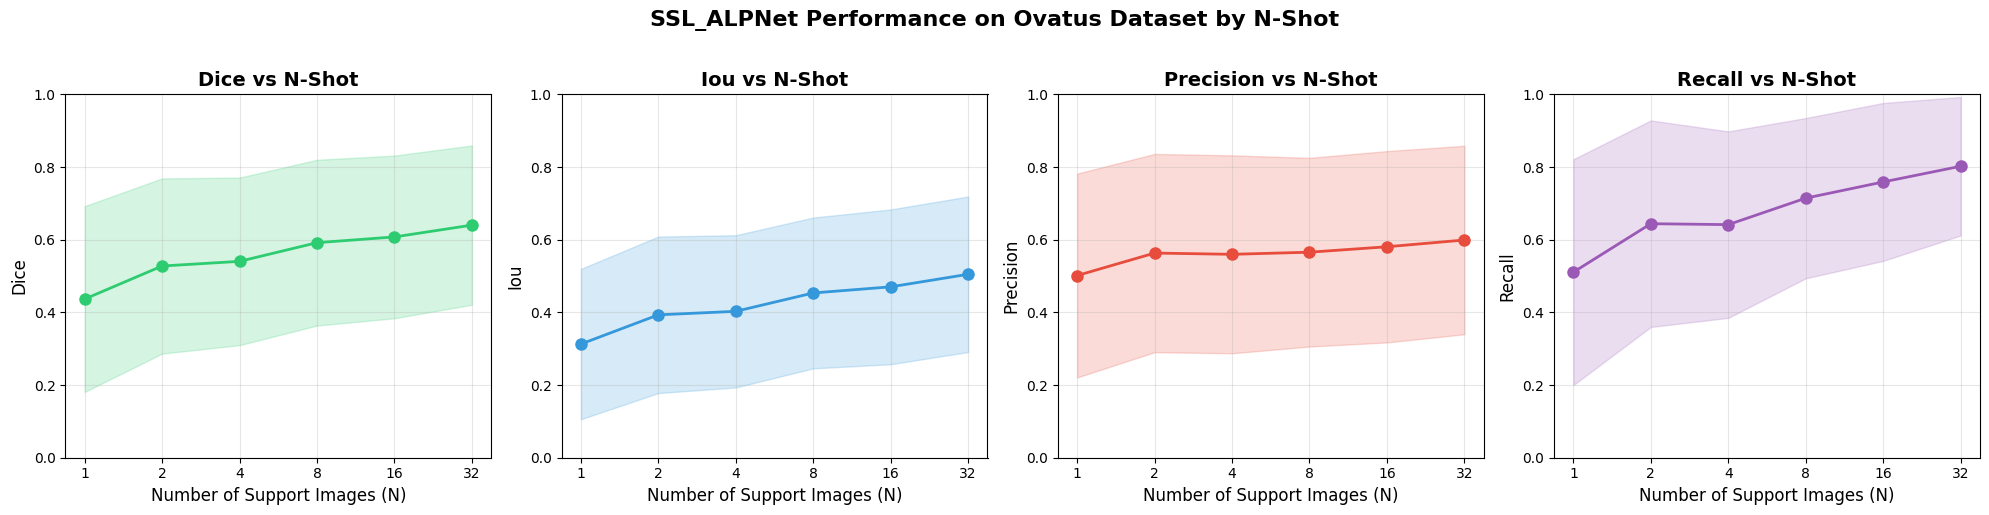


✅ Plot saved to ssl_alpnet_ovatus_metrics_by_N.png


In [12]:
# Plot results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics_names = ['dice', 'iou', 'precision', 'recall']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes, metrics_names, colors):
    means = df_avg[metric].values
    stds = df_avg[f'{metric}_std'].values
    
    ax.plot(N_SHOTS_LIST, means, 'o-', color=color, linewidth=2, markersize=8)
    ax.fill_between(N_SHOTS_LIST, means - stds, means + stds, alpha=0.2, color=color)
    ax.set_xlabel('Number of Support Images (N)', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_title(f'{metric.capitalize()} vs N-Shot', fontsize=14, fontweight='bold')
    ax.set_xscale('log', base=2)
    ax.set_xticks(N_SHOTS_LIST)
    ax.set_xticklabels(N_SHOTS_LIST)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.suptitle('SSL_ALPNet Performance on Ovatus Dataset by N-Shot', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ssl_alpnet_ovatus_metrics_by_N.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to ssl_alpnet_ovatus_metrics_by_N.png")

## 10. Per-Class Evaluation

In [13]:
# ================== EVALUATE PER CLASS ==================
N_SELECTED = 1  # Number of shots to use

print("=" * 80)
print(f"EVALUATING SSL_ALPNet ON OVATUS - PER CLASS METRICS (N={N_SELECTED})")
print("=" * 80)

class_metrics = {c: {'dice': [], 'iou': [], 'precision': [], 'recall': [], 'count': 0} 
                 for c in range(NUM_CLASSES)}

for idx in tqdm(range(len(test_set)), desc="Evaluating"):
    query_sample = test_set[idx]
    cls_idx = query_sample['class']
    
    if query_sample['mask'].sum() <= 10:
        continue
    
    support_samples = get_best_support_samples(support_pool, cls_idx, N_SELECTED)
    
    if len(support_samples) == 0:
        continue
    
    try:
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
        metrics = compute_metrics(pred_binary, gt_mask)
        
        for key in metrics:
            class_metrics[cls_idx][key].append(metrics[key])
        class_metrics[cls_idx]['count'] += 1
    except Exception as e:
        continue

# Create DataFrame
results_per_class = []
for cls_idx in range(NUM_CLASSES):
    if class_metrics[cls_idx]['count'] == 0:
        continue
    
    row = {
        'Class': cls_idx,
        'Name': LABEL_NAMES[cls_idx],
        'Samples': class_metrics[cls_idx]['count'],
        'Dice': np.mean(class_metrics[cls_idx]['dice']),
        'Dice_std': np.std(class_metrics[cls_idx]['dice']),
        'IoU': np.mean(class_metrics[cls_idx]['iou']),
        'Precision': np.mean(class_metrics[cls_idx]['precision']),
        'Recall': np.mean(class_metrics[cls_idx]['recall']),
    }
    results_per_class.append(row)

df_class = pd.DataFrame(results_per_class)

# Display
print("\n" + "=" * 100)
print(f"PER-CLASS RESULTS (N = {N_SELECTED}):")
print("=" * 100)
print(f"\n{'Class':>6} | {'Name':>25} | {'#Samples':>8} | {'Dice':>10} | {'IoU':>10} | {'Precision':>10} | {'Recall':>10}")
print("-" * 100)

for _, row in df_class.iterrows():
    print(f"{int(row['Class']):>6} | {row['Name']:>25} | {int(row['Samples']):>8} | "
          f"{row['Dice']:.4f}     | {row['IoU']:.4f}     | {row['Precision']:.4f}     | {row['Recall']:.4f}")

# Average
print("-" * 100)
print(f"{'AVG':>6} | {'':>25} | {df_class['Samples'].sum():>8} | "
      f"{df_class['Dice'].mean():.4f}     | {df_class['IoU'].mean():.4f}     | "
      f"{df_class['Precision'].mean():.4f}     | {df_class['Recall'].mean():.4f}")

# Save results
df_class.to_csv(f'ssl_alpnet_ovatus_per_class_N{N_SELECTED}.csv', index=False)
print(f"\n✅ Results saved to ssl_alpnet_ovatus_per_class_N{N_SELECTED}.csv")

EVALUATING SSL_ALPNet ON OVATUS - PER CLASS METRICS (N=1)


Evaluating: 100%|██████████| 132/132 [00:04<00:00, 28.18it/s]


PER-CLASS RESULTS (N = 1):

 Class |                      Name | #Samples |       Dice |        IoU |  Precision |     Recall
----------------------------------------------------------------------------------------------------
     0 |              nang_da_thuy |       24 | 0.5215     | 0.3783     | 0.6413     | 0.5464
     1 |             nang_don_thuy |       25 | 0.4322     | 0.3169     | 0.5435     | 0.4745
     2 |          nang_da_thuy_dac |       13 | 0.5647     | 0.4122     | 0.5836     | 0.6159
     3 |         nang_don_thuy_dac |       13 | 0.5265     | 0.3956     | 0.6654     | 0.5951
     4 |                      u_bi |       24 | 0.4271     | 0.3003     | 0.4915     | 0.5676
     5 |                     u_dac |       33 | 0.3428     | 0.2352     | 0.3878     | 0.4959
----------------------------------------------------------------------------------------------------
   AVG |                           |      132 | 0.4691     | 0.3397     | 0.5522     | 0.5492

✅ Results sa

In [14]:
# ================== EVALUATE PER CLASS ==================
N_SELECTED = 5  # Number of shots to use

print("=" * 80)
print(f"EVALUATING SSL_ALPNet ON OVATUS - PER CLASS METRICS (N={N_SELECTED})")
print("=" * 80)

class_metrics = {c: {'dice': [], 'iou': [], 'precision': [], 'recall': [], 'count': 0} 
                 for c in range(NUM_CLASSES)}

for idx in tqdm(range(len(test_set)), desc="Evaluating"):
    query_sample = test_set[idx]
    cls_idx = query_sample['class']
    
    if query_sample['mask'].sum() <= 10:
        continue
    
    support_samples = get_best_support_samples(support_pool, cls_idx, N_SELECTED)
    
    if len(support_samples) == 0:
        continue
    
    try:
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
        metrics = compute_metrics(pred_binary, gt_mask)
        
        for key in metrics:
            class_metrics[cls_idx][key].append(metrics[key])
        class_metrics[cls_idx]['count'] += 1
    except Exception as e:
        continue

# Create DataFrame
results_per_class = []
for cls_idx in range(NUM_CLASSES):
    if class_metrics[cls_idx]['count'] == 0:
        continue
    
    row = {
        'Class': cls_idx,
        'Name': LABEL_NAMES[cls_idx],
        'Samples': class_metrics[cls_idx]['count'],
        'Dice': np.mean(class_metrics[cls_idx]['dice']),
        'Dice_std': np.std(class_metrics[cls_idx]['dice']),
        'IoU': np.mean(class_metrics[cls_idx]['iou']),
        'Precision': np.mean(class_metrics[cls_idx]['precision']),
        'Recall': np.mean(class_metrics[cls_idx]['recall']),
    }
    results_per_class.append(row)

df_class = pd.DataFrame(results_per_class)

# Display
print("\n" + "=" * 100)
print(f"PER-CLASS RESULTS (N = {N_SELECTED}):")
print("=" * 100)
print(f"\n{'Class':>6} | {'Name':>25} | {'#Samples':>8} | {'Dice':>10} | {'IoU':>10} | {'Precision':>10} | {'Recall':>10}")
print("-" * 100)

for _, row in df_class.iterrows():
    print(f"{int(row['Class']):>6} | {row['Name']:>25} | {int(row['Samples']):>8} | "
          f"{row['Dice']:.4f}     | {row['IoU']:.4f}     | {row['Precision']:.4f}     | {row['Recall']:.4f}")

# Average
print("-" * 100)
print(f"{'AVG':>6} | {'':>25} | {df_class['Samples'].sum():>8} | "
      f"{df_class['Dice'].mean():.4f}     | {df_class['IoU'].mean():.4f}     | "
      f"{df_class['Precision'].mean():.4f}     | {df_class['Recall'].mean():.4f}")

# Save results
df_class.to_csv(f'ssl_alpnet_ovatus_per_class_N{N_SELECTED}.csv', index=False)
print(f"\n✅ Results saved to ssl_alpnet_ovatus_per_class_N{N_SELECTED}.csv")

EVALUATING SSL_ALPNet ON OVATUS - PER CLASS METRICS (N=5)


Evaluating: 100%|██████████| 132/132 [00:10<00:00, 12.12it/s]


PER-CLASS RESULTS (N = 5):

 Class |                      Name | #Samples |       Dice |        IoU |  Precision |     Recall
----------------------------------------------------------------------------------------------------
     0 |              nang_da_thuy |       24 | 0.6606     | 0.5099     | 0.6478     | 0.7253
     1 |             nang_don_thuy |       25 | 0.6367     | 0.4879     | 0.6692     | 0.7046
     2 |          nang_da_thuy_dac |       13 | 0.7022     | 0.5624     | 0.7325     | 0.7823
     3 |         nang_don_thuy_dac |       13 | 0.6346     | 0.4899     | 0.6924     | 0.7134
     4 |                      u_bi |       24 | 0.5056     | 0.3674     | 0.4973     | 0.6831
     5 |                     u_dac |       33 | 0.4077     | 0.2948     | 0.3805     | 0.5856
----------------------------------------------------------------------------------------------------
   AVG |                           |      132 | 0.5912     | 0.4520     | 0.6033     | 0.6990

✅ Results sa

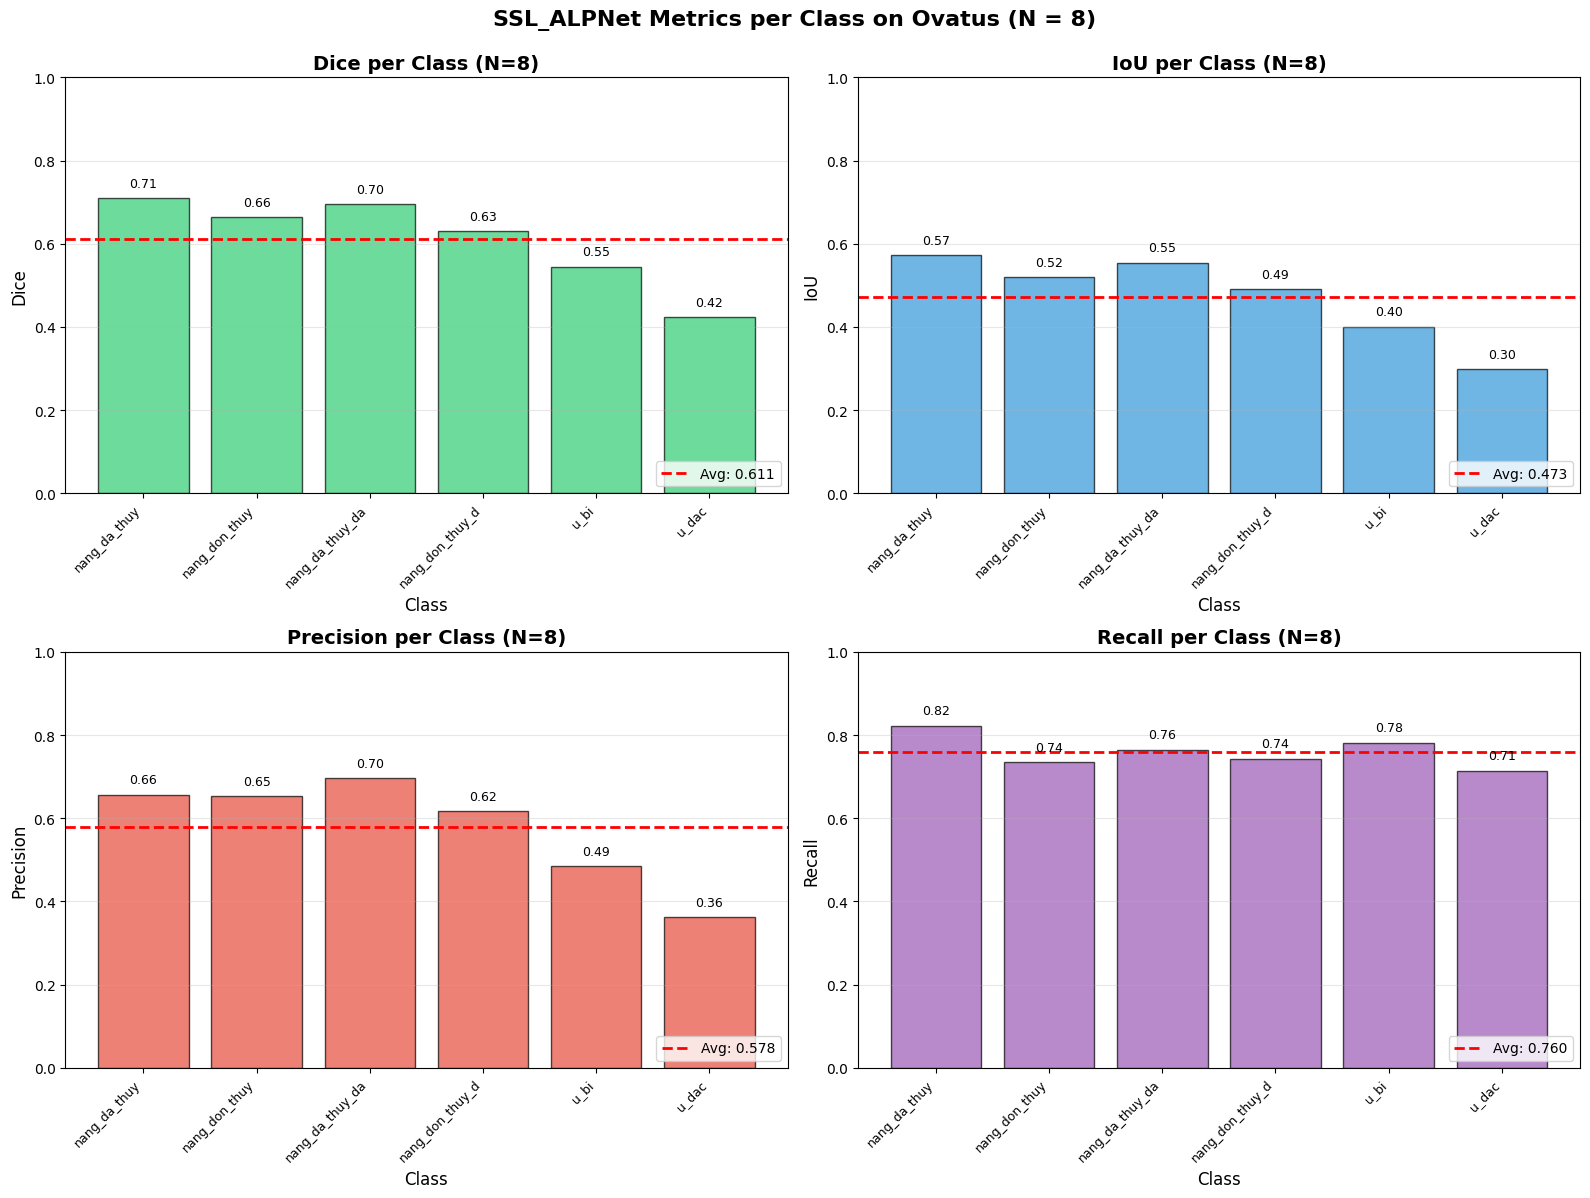


✅ Plot saved to ssl_alpnet_ovatus_metrics_per_class_N8.png


In [14]:
# Plot per-class results
if len(df_class) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    metrics_to_plot = ['Dice', 'IoU', 'Precision', 'Recall']
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

    for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
        x = np.arange(len(df_class))
        values = df_class[metric].values
        
        bars = ax.bar(x, values, color=color, alpha=0.7, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels([name[:15] for name in df_class['Name']], fontsize=9, rotation=45, ha='right')
        ax.set_xlabel('Class', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'{metric} per Class (N={N_SELECTED})', fontsize=14, fontweight='bold')
        ax.axhline(y=df_class[metric].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Avg: {df_class[metric].mean():.3f}')
        ax.legend(loc='lower right')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle(f'SSL_ALPNet Metrics per Class on Ovatus (N = {N_SELECTED})', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'ssl_alpnet_ovatus_metrics_per_class_N{N_SELECTED}.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Plot saved to ssl_alpnet_ovatus_metrics_per_class_N{N_SELECTED}.png")
else:
    print("No results to plot!")

## 11. Visualization Grid

Creating visualization grid...
Found 6 samples to visualize


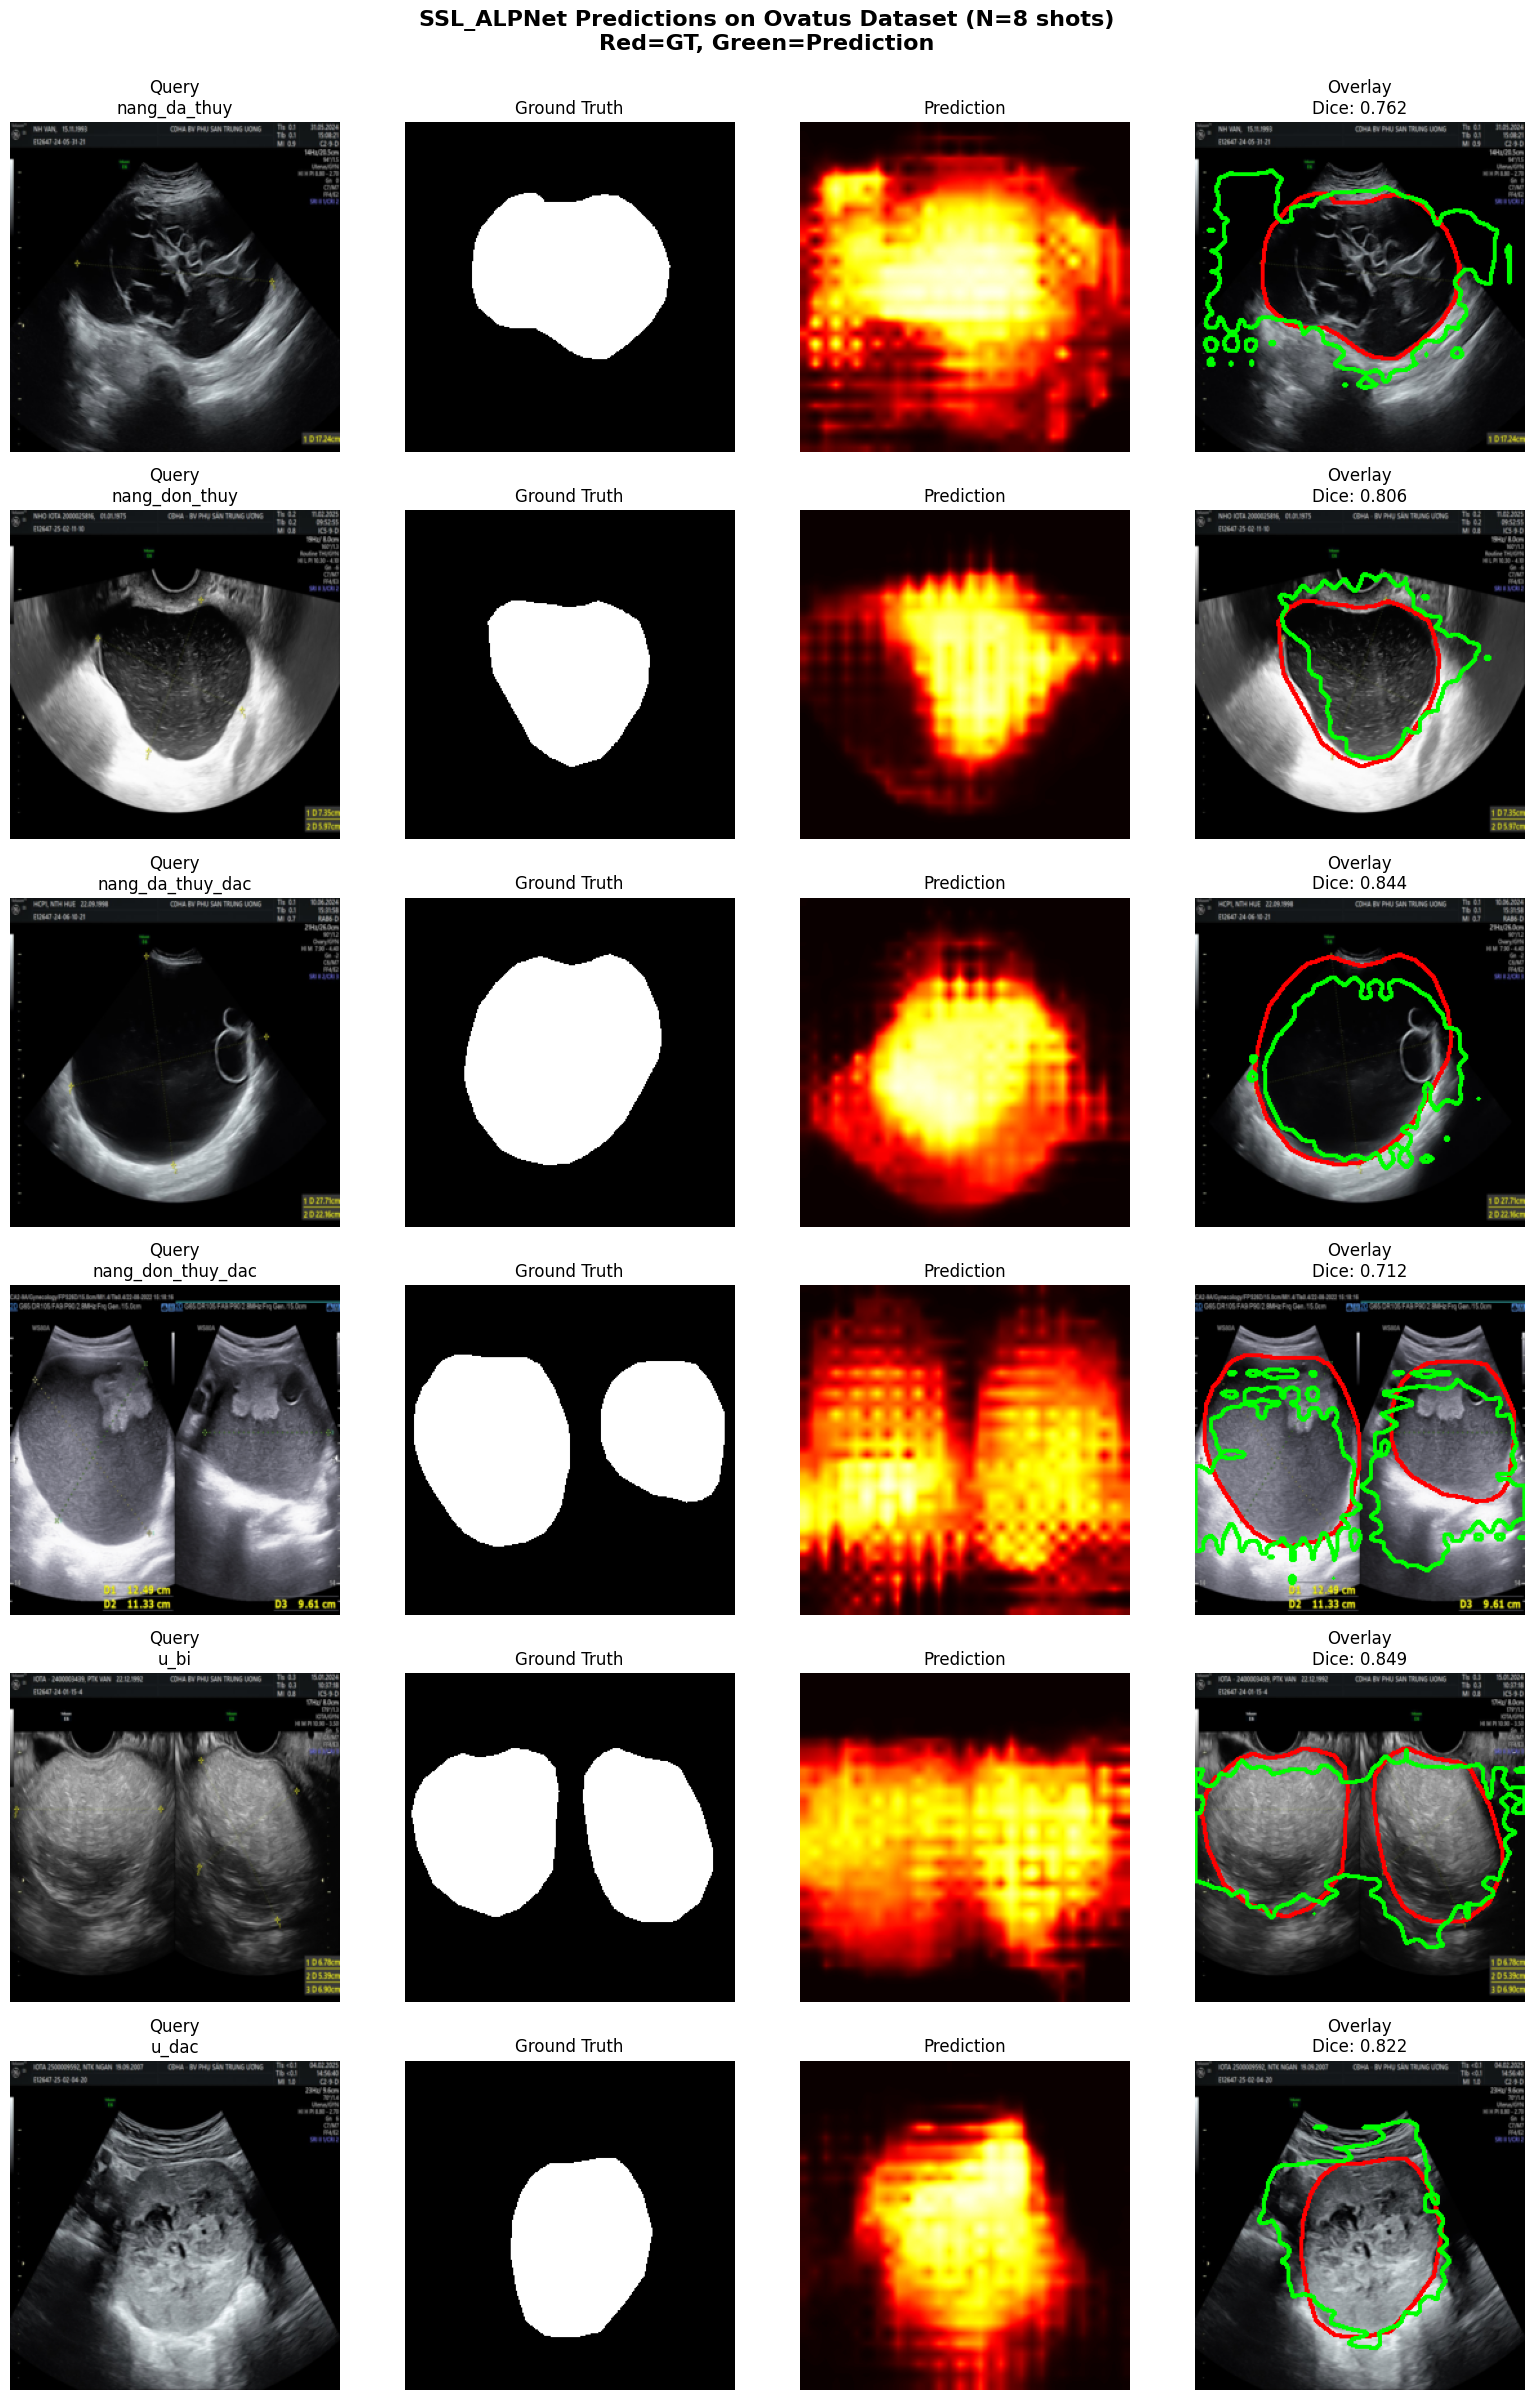


✅ Visualization saved to ssl_alpnet_ovatus_visualization_grid.png


In [15]:
# ================== VISUALIZATION GRID ==================
print("Creating visualization grid...")

N_VIS = 8  # Number of shots for visualization

# Specific images for each class
target_images = {
    0: "9ec4c59d-5e34-47a0-8d6e-bbcda6d633f1.jpg",  # nang_da_thuy
    1: "f653a06a-6fc7-4dbb-b49c-cf6eb2fbefa6.jpg",  # nang_don_thuy
    2: "f96cd989-a7a6-455e-9dc1-870ce4719c6b.jpg",  # nang_da_thuy_dac
    3: "21.7_0004.JPG",                             # nang_don_thuy_dac
    4: "b15cfe36-db12-4214-ba54-4d23bf4bada0.jpg",  # u_bi
    5: "774428f0-d621-42e9-a42f-11788b483880.jpg"   # u_dac
}

# Find samples by matching image filename
samples_to_visualize = []
for target_class, target_filename in target_images.items():
    query_sample = None
    for idx in range(len(test_set)):
        sample = test_set[idx]
        # Extract filename from path
        img_filename = os.path.basename(sample['img_path'])
        if img_filename == target_filename and sample['class'] == target_class:
            query_sample = sample
            break
    
    if query_sample is not None:
        samples_to_visualize.append(query_sample)
    else:
        print(f"⚠️ Warning: Could not find image {target_filename} for class {target_class} ({LABEL_NAMES[target_class]})")

NUM_SAMPLES = len(samples_to_visualize)
print(f"Found {NUM_SAMPLES} samples to visualize")

fig, axes = plt.subplots(NUM_SAMPLES, 4, figsize=(16, 4 * NUM_SAMPLES))

for sample_count, query_sample in enumerate(samples_to_visualize):
    target_class = query_sample['class']
    support_samples = get_best_support_samples(support_pool, target_class, N_VIS)
    
    if len(support_samples) == 0:
        print(f"⚠️ No support samples for class {target_class} ({LABEL_NAMES[target_class]})")
        continue
    
    try:
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
        metrics = compute_metrics(pred_binary, gt_mask)
        
        # Query image
        img_show = query_sample['image'].transpose(1, 2, 0)
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)
        
        axes[sample_count, 0].imshow(img_show)
        axes[sample_count, 0].set_title(f"Query\n{LABEL_NAMES[target_class]}")
        axes[sample_count, 0].axis('off')
        
        # Ground truth
        axes[sample_count, 1].imshow(gt_mask.cpu().numpy(), cmap='gray')
        axes[sample_count, 1].set_title(f"Ground Truth")
        axes[sample_count, 1].axis('off')
        
        # Prediction
        axes[sample_count, 2].imshow(pred_prob.cpu().numpy(), cmap='hot', vmin=0, vmax=1)
        axes[sample_count, 2].set_title(f"Prediction")
        axes[sample_count, 2].axis('off')
        
        # Overlay
        overlay = (img_show * 255).astype(np.uint8)
        gt_np = gt_mask.cpu().numpy()
        pred_np = pred_binary.cpu().numpy()
        
        # Draw contours
        gt_contours, _ = cv2.findContours((gt_np > 0.5).astype(np.uint8), 
                                           cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        pred_contours, _ = cv2.findContours((pred_np > 0.5).astype(np.uint8), 
                                             cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        cv2.drawContours(overlay_rgb, gt_contours, -1, (0, 0, 255), 2)  # Red for GT
        cv2.drawContours(overlay_rgb, pred_contours, -1, (0, 255, 0), 2)  # Green for Pred
        overlay_rgb = cv2.cvtColor(overlay_rgb, cv2.COLOR_BGR2RGB)
        
        axes[sample_count, 3].imshow(overlay_rgb)
        axes[sample_count, 3].set_title(f"Overlay\nDice: {metrics['dice']:.3f}")
        axes[sample_count, 3].axis('off')
        
    except Exception as e:
        print(f"Error visualizing class {target_class} ({LABEL_NAMES[target_class]}): {e}")
        continue

plt.suptitle(f'SSL_ALPNet Predictions on Ovatus Dataset (N={N_VIS} shots)\nRed=GT, Green=Prediction', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.savefig('ssl_alpnet_ovatus_visualization_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to ssl_alpnet_ovatus_visualization_grid.png")

## 12. Summary

In [41]:
print("=" * 80)
print("📊 SSL_ALPNet EVALUATION SUMMARY ON OVATUS DATASET")
print("=" * 80)

print(f"\n🔧 Configuration:")
print(f"   Model: FewShotSeg (SSL_ALPNet)")
print(f"   Backbone: DeepLabV3-ResNet101")
print(f"   Image size: {RESIZE_TO}")
print(f"   Validation window size: {VAL_WSIZE}")

print(f"\n📁 Dataset:")
print(f"   Total samples: {len(dataset)}")
print(f"   Support pool: {len(support_pool)} samples")
print(f"   Test set: {len(test_set)} samples")
print(f"   Number of classes: {NUM_CLASSES}")

if len(df_avg) > 0:
    best_N = df_avg.loc[df_avg['dice'].idxmax()]
    print(f"\n🏆 Best N-shot result:")
    print(f"   N = {int(best_N['N'])}")
    print(f"   Dice: {best_N['dice']:.4f} ± {best_N['dice_std']:.4f}")
    print(f"   IoU: {best_N['iou']:.4f} ± {best_N['iou_std']:.4f}")

if len(df_class) > 0:
    print(f"\n📈 Per-class summary (N={N_SELECTED}):")
    print(f"   Average Dice: {df_class['Dice'].mean():.4f}")
    print(f"   Average IoU: {df_class['IoU'].mean():.4f}")
    print(f"   Best class: {df_class.loc[df_class['Dice'].idxmax(), 'Name']} "
          f"(Dice={df_class['Dice'].max():.4f})")
    print(f"   Worst class: {df_class.loc[df_class['Dice'].idxmin(), 'Name']} "
          f"(Dice={df_class['Dice'].min():.4f})")

print("\n" + "=" * 80)
print("✅ Evaluation complete!")
print("=" * 80)

📊 SSL_ALPNet EVALUATION SUMMARY ON OVATUS DATASET

🔧 Configuration:
   Model: FewShotSeg (SSL_ALPNet)
   Backbone: DeepLabV3-ResNet101
   Image size: (256, 256)
   Validation window size: 2

📁 Dataset:
   Total samples: 605
   Support pool: 473 samples
   Test set: 132 samples
   Number of classes: 6

🏆 Best N-shot result:
   N = 32
   Dice: 0.6348 ± 0.2175
   IoU: 0.4985 ± 0.2127

📈 Per-class summary (N=8):
   Average Dice: 0.5956
   Average IoU: 0.4565
   Best class: nang_da_thuy_dac (Dice=0.7418)
   Worst class: u_dac (Dice=0.4271)

✅ Evaluation complete!
